# [Lecture 03 - Geocentric Models](https://youtu.be/tNOu-SEacNU?si=rp_4kWbSVvQChAiv)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import arviz as az

import numpy as np

import pandas as pd

import pymc as pm

import statsmodels.formula.api as smf

import xarray as xr

from matplotlib import pyplot as plt

from scipy import stats as stats

import utils as utils

Watermark:
----------
Last updated: 2023-09-26T12:38:28.850331-04:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.15.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas     : 2.1.0
xarray     : 2023.8.0
pymc       : 5.8.0
scipy      : 1.11.2
numpy      : 1.25.2
arviz      : 0.16.1
statsmodels: 0.14.0
matplotlib : 3.7.2



# Linear Regression
- **Geocentric**
  - unreasonably good approximations, despite it always being incorrect
  - can be used as a cog in a causal analysis system, despite being an innaccurate mechanistic model of real phenonena

![Alt text](images/image-25.png)

- **Gaussian**
  - General error model
  - Abstracts away details, allowing us to make macro inferences, without having to incorporate micro phenonena

 
  
# Why Normal?
### Two arguments

1. Generative: summed fluctuations (see below) tend toward Normal distribution
2. Inferential: For estimating mean and variance, the Normal is the least informative (fewest assumptions), in the maximum entropy sense

> Variables do not need to be Normally-distributed in order estimate the correct mean and variance using a Gaussian error model.


### Generating Normal distribution from summation of decisions
- Simulate a group of people randomly walking left-right, starting from a central location
- Resulting positions are the summation of many left-and right -- the result is Normally-distributed
- Normal distribution falls out processes where deviations are summed (also products)
  - many more combinations that lead to middle 
  - compared to combinations that lead to extremes e.g. a run of 10 heads in a row

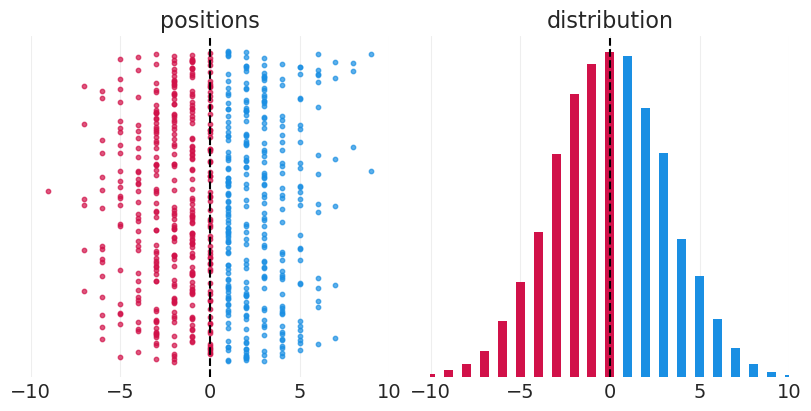

In [10]:
n_people = 10000
n_steps = 1000

step_size = .1
steps = step_size * (2 * stats.bernoulli(p=.5).rvs(size=(n_people, n_steps)) - 1)

positions = np.round(np.sum(steps, axis=1))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(axs[0])
plt.axvline(0, color='k', linestyle='--')
for ii, pos in enumerate(positions[::15]):
    color = 'C1' if pos > 0 else 'C0'
    plt.scatter(x=pos, y=ii, color=color, alpha=.7, s=10)

plt.xlim([-10, 10])
plt.yticks([])
plt.title("positions")

# Plot histogram
position_unique, position_counts = np.unique(positions, return_counts=True)
positive_idx = position_unique > 0
negative_idx = position_unique <= 0
plt.sca(axs[1])
plt.bar(position_unique[positive_idx], position_counts[positive_idx], width=.5, color='C1');
plt.bar(position_unique[negative_idx], position_counts[negative_idx], width=.5, color='C0');
plt.axvline(0, color='k', linestyle='--')
plt.xlim([-10, 10])
plt.yticks([])
plt.title("distribution");

# Linear Regression

## Howell Dataset

### (1) Question Estimand 
- Describe the association between **weight** and **height**
- We'll focus on **adult weight** -- Adult height is approximately linear


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


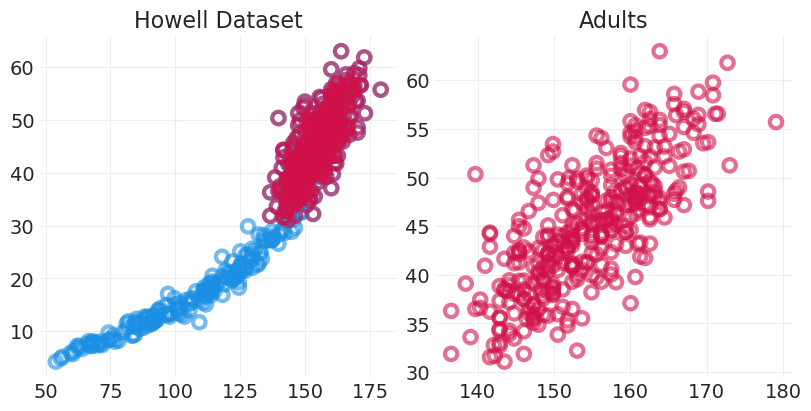

In [11]:
HOWELL = utils.load_data("Howell1")
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(axs[0])
utils.plot_scatter(HOWELL.height, HOWELL.weight, color='C1')
plt.title("Howell Dataset")

ADULT_HOWELL = HOWELL[HOWELL.age >= 18]
plt.sca(axs[0])
utils.plot_scatter(ADULT_HOWELL.height, ADULT_HOWELL.weight)
plt.sca(axs[1])
utils.plot_scatter(ADULT_HOWELL.height, ADULT_HOWELL.weight)
plt.title("Adults")
HOWELL.head()

### (2) Scientific Model
How does **height** influence **weight**?

$$
\begin{align}
H \rightarrow W \\
W = f(H)
\end{align}
$$

i.e. *"Weight is some function of height"*

### (3) Generative Models

Options

1. Dynamic - relationship changes over time
2. Static - constant trend over time

$$W = f(H, U)$$

*"Weight is a function of height, H and unobserved stuff, U"*

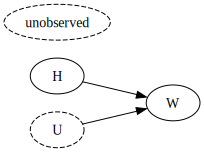

In [12]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("U", "W")
    ],
    node_props={
        "U": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    graph_direction="LR"
)

### Linear regression model

We need a function that maps adult weight as a proportion of height plus some unobserved/unaccounted-for causes. Enter **Linear Regression**:

$$W = \beta H + U$$


### Generative model description:
$$
\begin{align}
W_i &\sim \beta H_i + U_i \\
U_i &\sim \text{Normal}(0, \sigma) \\
H_i &\sim \text{Uniform}(130, 170)
\end{align}
$$

### Describing models
- Variables on the left
- Definition on right
- $\sim$ indicates sampling from a distribution
  - e.g. $H_i \sim \text{Uniform}(130, 170)$ is definition that _height is distributed uniformly between 120 and 170_
- $=$ indicates expectation or (deterministic) equality
  - e.g. $W_i \sim \beta H_i + U_i$ is definition of equation for _expected weight_
- subscripts $i$ indicates index of a observation/individual
- generally code will be written in opposite direction, because you need variables defined in order to be referenced/composed

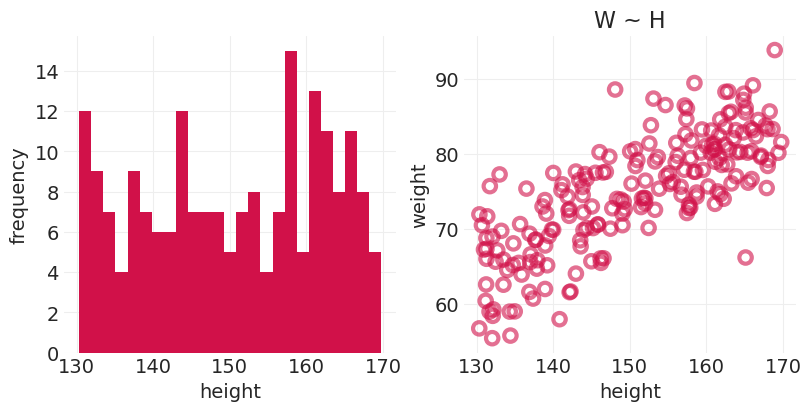

In [13]:
def simulate_weight(H, beta, sigma):
    """
    Generative model describe above, simulate weight given height, H,
    proportional coefficient beta, and the standard deviation of
    unobserved (Normally-distributed) noise, sigma.
    """
    n_heights = len(H)
    
    # unobserved noise
    U = stats.norm.rvs(0, sigma, size=n_heights)
    return beta * H + U

n_heights = 200
MIN_HEIGHT = 130
MAX_HEIGHT = 170
H = stats.uniform.rvs(MIN_HEIGHT, MAX_HEIGHT - MIN_HEIGHT, size=n_heights)
W = simulate_weight(H, beta=0.5, sigma=5)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.sca(axs[0])
plt.hist(H, bins=25)
plt.xlabel("height")
plt.ylabel("frequency")

plt.sca(axs[1])
utils.plot_scatter(H, W)
plt.xlabel("height")
plt.ylabel("weight")
plt.title("W ~ H");

### Linear Regression

Estimate how the average weight changes with a change in height:

$$E[W_i | H_i] = \alpha + \beta H_i$$

- $E[W_i | H_i]$: **average weight** conditioned on height
- $\alpha$: **intercept** of line
- $\beta$: **slope** of line


### Posterior Distribution

$$
p(\alpha, \beta, \sigma) = \frac{p(W_i | \alpha, \beta, \sigma) p(\alpha, \beta, \sigma)}{Z}
$$

- The only estimator in Bayesian data analysis

- $p(\alpha, \beta, \sigma)$ -- **Posterior**: Probability of a specific line (model)
- $p(W_i | \alpha, \beta, \sigma)$ -- **Likelihood**: The number of ways the generative proces (line) could have produced the data 
    - aka the "Garden of Forking Data"
- $p(\alpha, \beta, \sigma)$ -- **Prior**: the previous Posterior (sometimes with no data)
- $Z$ -- **normalizing constant**

Common parameterization

$$
\begin{align}
W_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta H_i
\end{align}
$$

_$W$ is distributed normally with mean $\mu$ that is a linear function of $H$_

### Grid Approximate Posterior

For the following grid approximation simulation, we'll use a utility function `utils.simulate_2_parameter_bayesian_learning` for simulating general Bayeisan posterior update simulation. For the API, see `utils.py`

In [14]:
help(utils.simulate_2_parameter_bayesian_learning)

Help on function simulate_2_parameter_bayesian_learning in module utils:

simulate_2_parameter_bayesian_learning(x_obs, y_obs, param_a_grid, param_b_grid, true_param_a, true_param_b, model_func, posterior_func, n_posterior_samples=3, param_labels=None, data_range_x=None, data_range_y=None)
    General function for simulating Bayesian learning in a 2-parameter model
    using grid approximation.
    
    Parameters
    ----------
    x_obs : np.ndarray
        The observed x values
    y_obs : np.ndarray
        The observed y values
    param_a_grid: np.ndarray
        The range of values the first model parameter in the model can take.
        Note: should have same length as param_b_grid.
    param_b_grid: np.ndarray
        The range of values the second model parameter in the model can take.
        Note: should have same length as param_a_grid.
    true_param_a: float
        The true value of the first model parameter, used for visualizing ground
        truth
    true_param_b: f

##### Functions for `simulate_2_parameter_bayesian_learning`

In [15]:
# Model function required for simulation
def linear_model(x, intercept, slope):
    return intercept + slope * x

# Posterior function required for simulation
def linear_regression_posterior(x_obs, y_obs, intercept_grid, slope_grid, likelihood_prior_std = 1.0):
    
    # Convert params to 1-d arrays
    if np.ndim(intercept_grid) > 1:
        intercept_grid = intercept_grid.ravel()
    
    if np.ndim(slope_grid):
        slope_grid = slope_grid.ravel()
    
    log_prior_intercept = stats.norm(0, 1).logpdf(intercept_grid)
    log_prior_slope = stats.norm(0, 1).logpdf(slope_grid)
    
    log_likelihood = np.array(
        [
            stats.norm(
                intercept + slope * x_obs,
                likelihood_prior_std
            ).logpdf(y_obs) for intercept, slope in zip(intercept_grid, slope_grid)
        ]
    ).sum(axis=1)
    
    # Posterior is equal to the product of likelihood and priors (here a sum in log scale)
    log_posterior = log_likelihood + log_prior_intercept + log_prior_slope

    # Convert back to natural scale
    return np.exp(log_posterior - log_posterior.max())

#### Simulating Posterior Updates

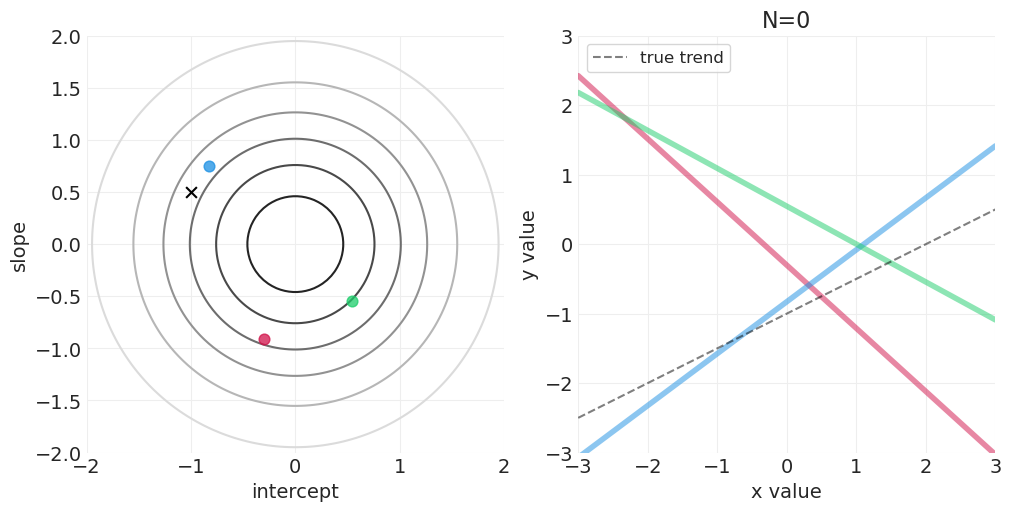

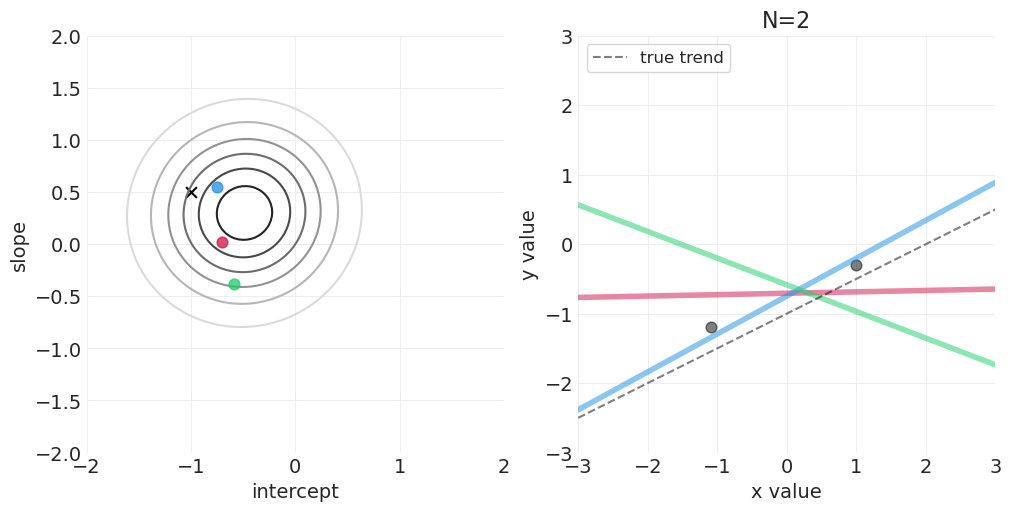

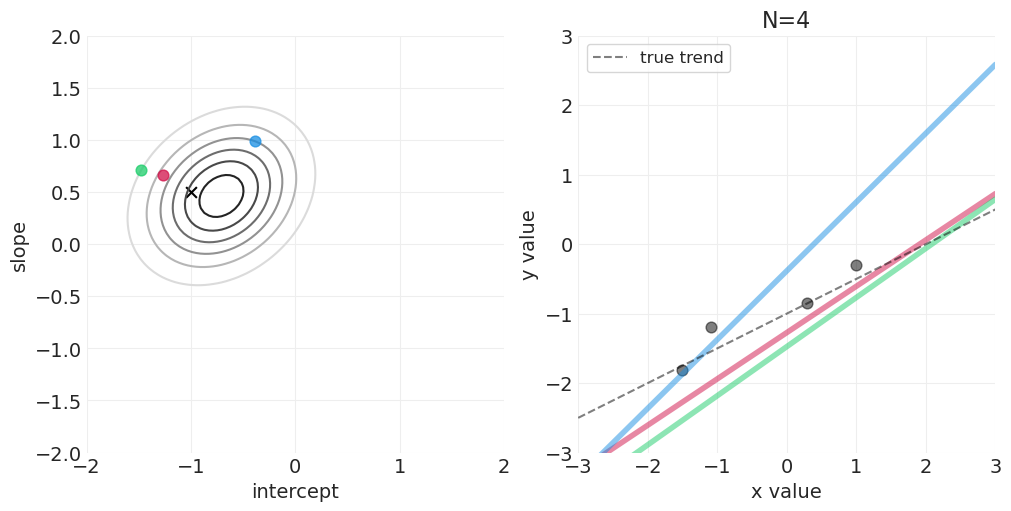

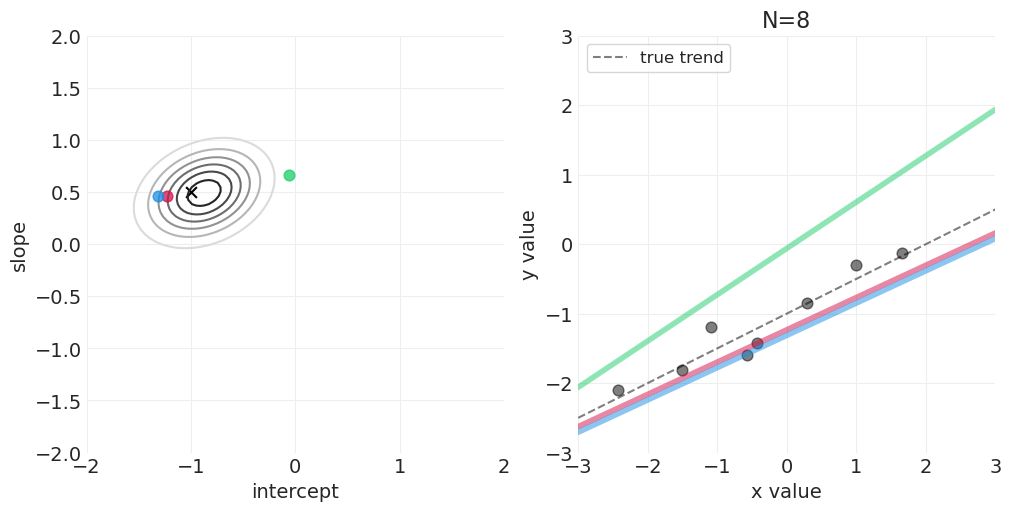

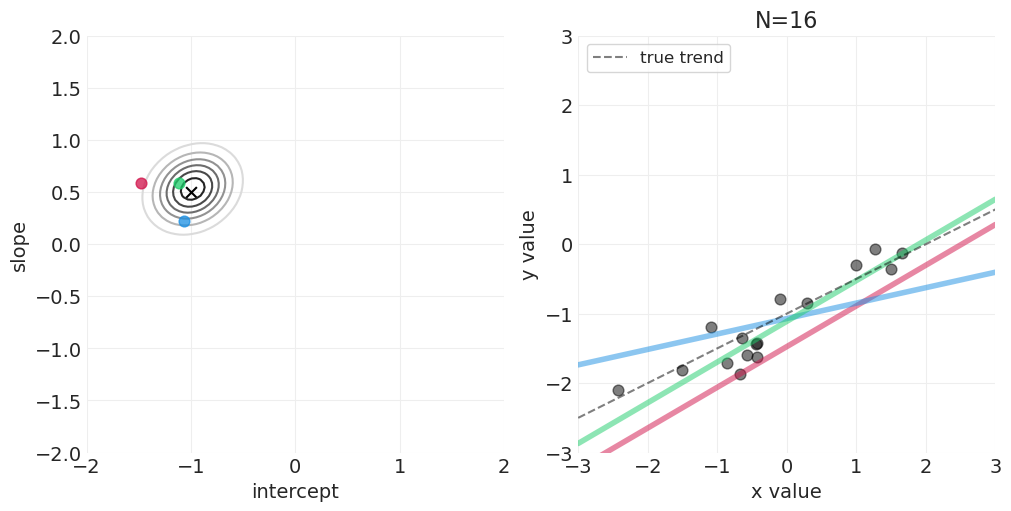

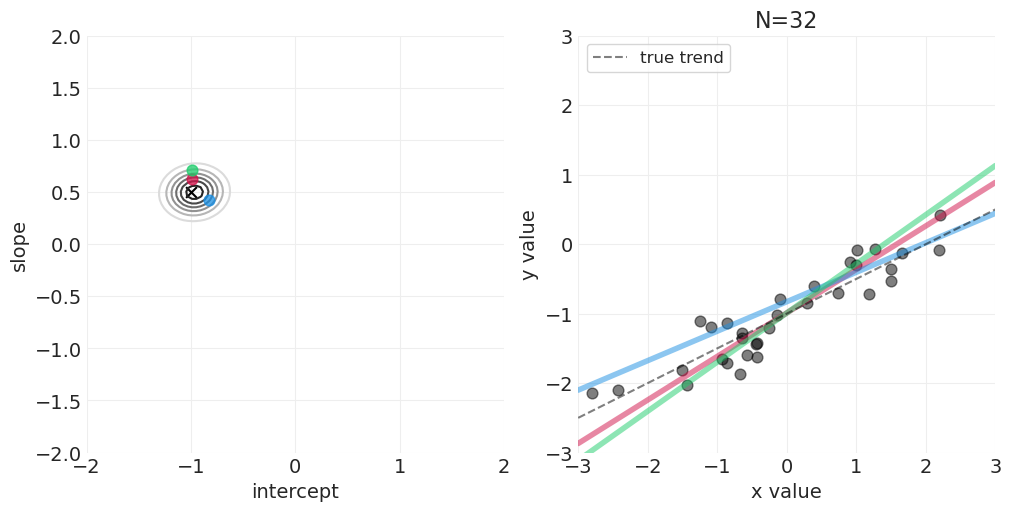

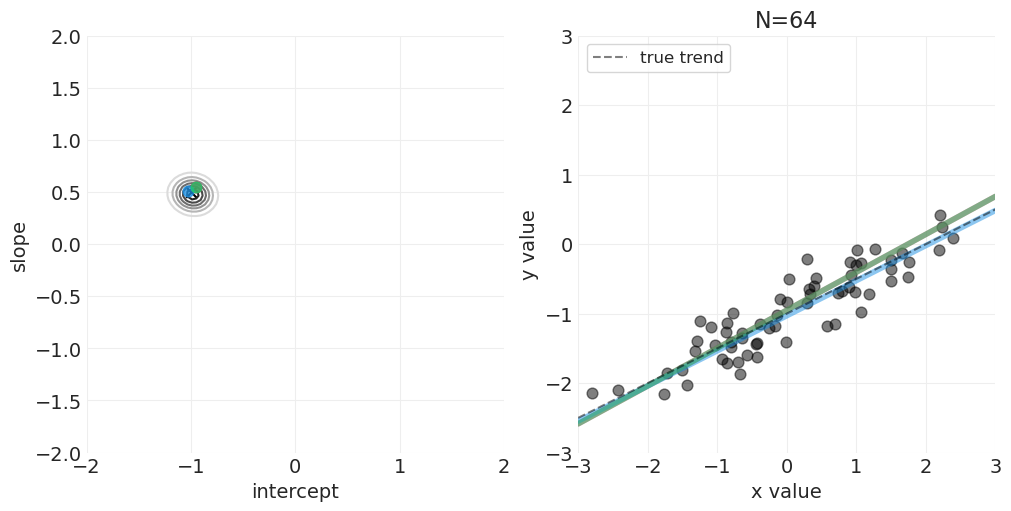

In [16]:
# Generate standardized regression data for demo
np.random.seed(123)
RESOLUTION = 100
N_DATA_POINTS = 64

# Ground truth parameters
SLOPE = 0.5
INTERCEPT = -1

x = stats.norm().rvs(size=N_DATA_POINTS)
y = INTERCEPT + SLOPE * x + stats.norm.rvs(size=N_DATA_POINTS) * 0.25

slope_grid = np.linspace(-2, 2, RESOLUTION)
intercept_grid = np.linspace(-2, 2, RESOLUTION)

# Vary the sample size to show how the posterior adapts to more and more data
for n_samples in [0, 2, 4, 8, 16, 32, 64]:
    # Run the simulation
    utils.simulate_2_parameter_bayesian_learning(
        x_obs=x[:n_samples],
        y_obs=y[:n_samples],
        param_a_grid=intercept_grid,
        param_b_grid=slope_grid,
        true_param_a=INTERCEPT,
        true_param_b=SLOPE,
        model_func=linear_model,
        posterior_func=linear_regression_posterior,
        param_labels=['intercept', 'slope'],
        data_range_x=(-3, 3), data_range_y=(-3, 3)
    )

### Enough Grid Approximation
McElreath uses Quadratic Approximation--`quap`--for the first half of the lectures, which _can_ speed up model fitting for continuous models that have posteriors that can be approximated with a multi-dimensional Normal distribution. However, we'll just use PyMC MCMC implementations for all examples without loss of generality. For the earlier examples in the lecture series where `quap` is being used, MCMC samples perfectly fast anyways.

## (4) Validate the model
### Validate Assumptions with **Prior Predictive Distribution**
- Priors should express scientific knowledge, _but softly_
- For example, when Height is 0, Weight shoudl be 0, right?
- Weight should increase (on average) with height -- i.e. $\beta > 0$
- Weight (kg) should be less than Height (cm)
- variances should be positive

$$
\begin{align}
\alpha &\sim \text{Normal}(0, 10) \\
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Uniform}(0, 10) \\
\end{align}
$$

### More on Priors
- We can understand the implications of priors by running simulations
- **There are no correct priors**, only those that are scientifically justifiable
- Priors are less important with simple models
- **Priors are very important in complex models**

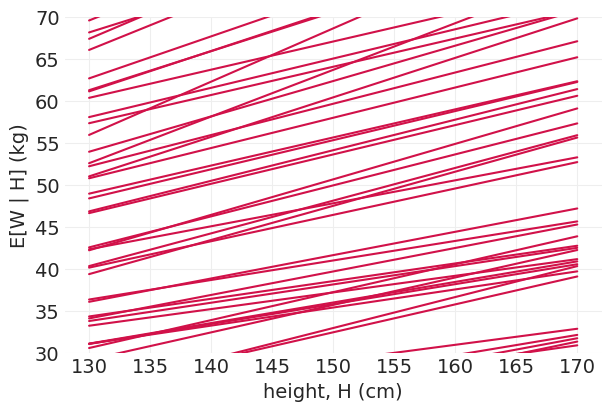

In [17]:
n_simulations = 100

alphas = np.random.normal(0, 10, n_simulations)
betas = np.random.uniform(0, 1, n_simulations)  # beta should all be positive

heights_ = np.linspace(130, 170, 3)

fig, ax = plt.subplots(figsize=(6, 4))
for a, b in zip(alphas, betas):
    weights_ = a + b * heights_
    plt.plot(heights_, weights_, color='C0')

plt.xlabel("height, H (cm)")
plt.ylabel("E[W | H] (kg)")
plt.ylim((30, 70));

## Simulation-based Validation & Calibration
- Simulate data with varying parameters
- Vary data-generating parameters (e.g. slope) that are analogous to the model; make sure the estimator tracks
- Make sure that at large sample sizes, data-generating parameters can be recovered
- Same for confounds/unkowns


In [18]:
linear_regression_inferences = []
linear_regression_models = []

sample_sizes = [1, 2, 10, 20, 50, len(H)]

for sample_size in sample_sizes:
    print(f"Sample size: {sample_size}")
    with pm.Model() as model:
        
        # Mutable data for posterior predictive visualization
        H_ = pm.MutableData("H", H[:sample_size], dims="obs_id")
        
        # Priors
        sigma = pm.Uniform("sigma", 0, 10)  # Noise variance
        alpha = pm.Normal("alpha", 0, 10)  # Intercept
        beta = pm.Uniform("beta", 0, 1)  # slope
        
        # Likelihood
        mu = alpha + beta * H_
        pm.Normal("W_obs", mu, sigma, observed=W[:sample_size], dims="obs_id")
        
        # Sample posterior
        inference = pm.sample(target_accept=.99)
        
        linear_regression_inferences.append(inference)
        linear_regression_models.append(model)
        

Sample size: 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


Sample size: 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Sample size: 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Sample size: 20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Sample size: 50


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Sample size: 200


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


### Test Model Validity with Posterior Predictive Distribution
Below we show:
- how the posterior becomes more specific with different numbers of observations
- how the posterior is "made of lines" -- there are an infinite number of possible lines that can be drawn from the posterior
- confidence intervals can be established to communicate the uncertainty of the posterior's fit to the data

Sample size: 1


Sampling: [W_obs]
Sampling: [W_obs]


Sample size: 2


Sampling: [W_obs]


Sample size: 10


Sampling: [W_obs]


Sample size: 20


Sampling: [W_obs]


Sample size: 50


Sampling: [W_obs]


Sample size: 200


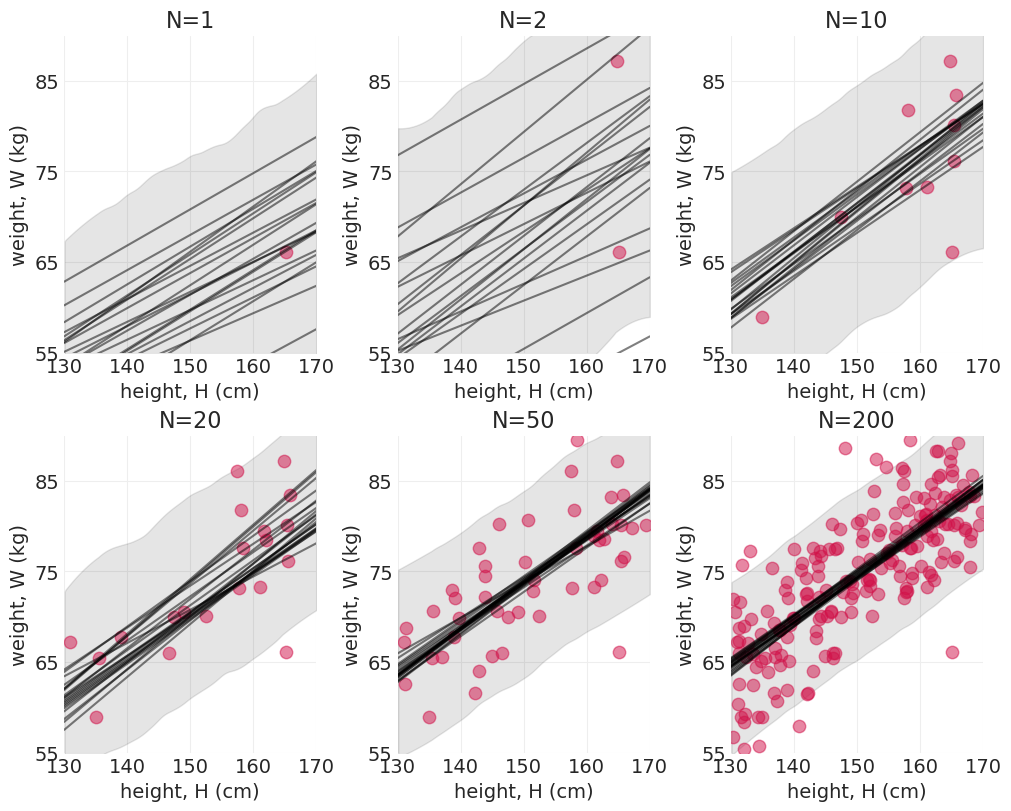

In [19]:
N_SHOW = 20
MIN_WEIGHT = 55
MAX_WEIGHT = 90

def plot_linear_regression_posterior_predictive(
    model, inference,
    min_height=MIN_HEIGHT,
    max_height=MAX_HEIGHT,
    min_weight=MIN_WEIGHT,
    max_weight=MAX_WEIGHT,
    N_SHOW = 20
):
    xs = np.linspace(min_height, max_height, 30)
    H_ = xr.DataArray(xs)
    
    # Sample Posterior Predictive with full range of heights
    with model:
        pm.set_data({'H': H_})
        ppd = pm.sample_posterior_predictive(
            inference,
            var_names=['W_obs'],
            predictions=True,
            return_inferencedata=True,
            progressbar=False
        )
        
    # Plot Posterior Predictive HDI
    az.plot_hdi(H_, ppd.predictions["W_obs"], color='k', fill_kwargs=dict(alpha=.1))
    
    # Plot Posterior
    posterior = inference.posterior
    lines = posterior['alpha'] + posterior['beta'] * H_
    for l in lines[0, :N_SHOW, :]:
        plt.plot(xs, l, color='k', alpha=.5, zorder=20)
       
    # Formatting
    plt.xticks(np.arange(min_height, max_height + 1, 10))
    plt.xlim([min_height, max_height])    
    plt.xlabel("height, H (cm)")
    
    plt.ylim([min_weight, max_weight])
    plt.yticks(np.arange(min_weight, max_weight, 10))
    plt.ylabel("weight, W (kg)")
    

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for ii, (sample_size, model, inference) in enumerate(
        zip(sample_sizes, linear_regression_models, linear_regression_inferences)
    ):
    print(f"Sample size: {sample_size}")
    plt.sca(axs[ii // 3][ii % 3])
    
    # Plot training data
    plt.scatter(H[:sample_size], W[:sample_size], s=80, zorder=20, alpha=.5)
    plot_linear_regression_posterior_predictive(model, inference)
    plt.title(f"N={sample_size}")


## (5) Analyse the data

In [20]:
with pm.Model() as howell_model:

    # Mutable data for posterior predictive / visualization
    H_ = pm.MutableData("H", ADULT_HOWELL.height.values, dims="obs_ids")

    # priors
    sigma = pm.Uniform("sigma", 0, 10)  # Noise variance
    alpha = pm.Normal("alpha", 0, 10)  # Intercept
    beta = pm.Uniform("beta", 0, 1)  # Slope

    # likelihood
    mu = alpha + beta * H_
    pm.Normal("W_obs", mu, sigma, observed=ADULT_HOWELL.weight.values, dims="obs_ids")

    # Sample posterior
    howell_inference = pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [21]:
az.summary(howell_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-43.383,4.182,-50.854,-35.564,0.150,0.108,781.0,884.0,1.00
sigma,4.285,0.170,3.990,4.625,0.005,0.004,1196.0,1009.0,1.01
beta,0.572,0.027,0.523,0.621,0.001,0.001,782.0,968.0,1.00


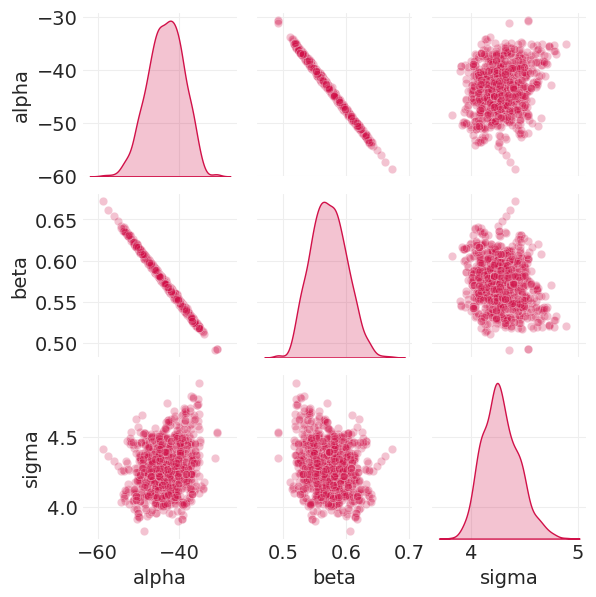

In [22]:
from seaborn import pairplot 

pairplot(
    pd.DataFrame(
        
        {
            "alpha": howell_inference.posterior.sel(chain=0)['alpha'],
            "beta": howell_inference.posterior.sel(chain=0)['beta'],
            "sigma": howell_inference.posterior.sel(chain=0)['sigma'],
        }
    ),
    diag_kind="kde",
    plot_kws={"alpha": .25},
    height=2
);

### Obey The Law: 
- **parameters are not independent**
- **parameters cannot be interpreted in isolation**

Instead...**Push out posterior predictions**

Below, we again show:
- how the posterior is "made of lines" -- there are an infinite number of possible lines that can be drawn from the posterior
- confidence intervals can be established to communicate the uncertainty of the posterior's fit to the data


Sampling: [W_obs]


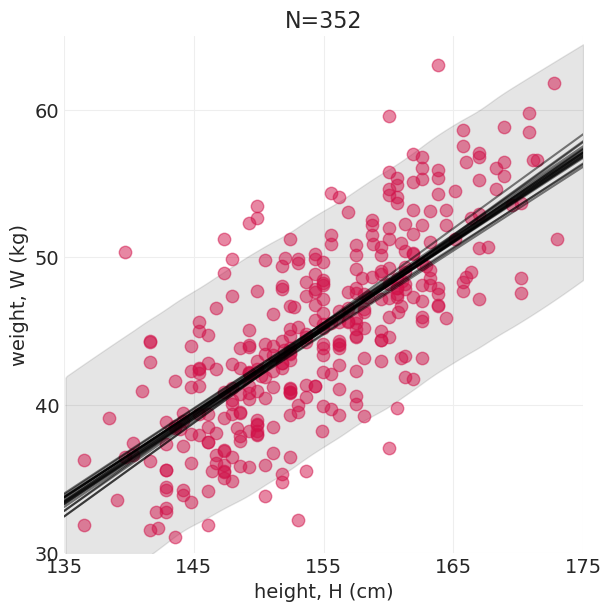

In [23]:
plt.subplots(figsize=(6, 6))
plt.scatter(ADULT_HOWELL.height.values, ADULT_HOWELL.weight.values, s=80, zorder=20, alpha=.5)
plot_linear_regression_posterior_predictive(
    howell_model,
    howell_inference,
    min_height=135,
    max_height=175,
    min_weight=30,
    max_weight=65
)  
plt.title(f"N={len(ADULT_HOWELL)}");